In [5]:
import sys
import numpy as np
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt 
from bandits.utils import score
import argparse
from bandits.scripts.create_movielens_dataset import get_ratings_1m

In [6]:
def ucb1_policy(df, t, ucb_scale=2.0,bayesian=False,n=5):
	'''
	Applies UCB1 policy to generate movie recommendations
	args:
		df: dataframe. Dataset to apply UCB policy to.
		ucb_scale: float. Most implementations use 2.0.
		t: int. represents the current time step.
	'''
	scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
	scores.columns = ['mean', 'count', 'std']
	if bayesian == 'TRUE':
		scores['ucb'] = scores['mean'] + (ucb_scale * scores['std'] / np.sqrt(scores['count']))
	else:
		scores['ucb'] = scores['mean'] + np.sqrt(
				(
					(2 * np.log10(t)) /
					scores['count']
				)
			)
	scores['movieId'] = scores.index
	scores = scores.sort_values('ucb', ascending=False)
	recs = scores.loc[scores.index[0:n], 'movieId'].values
	return recs

In [7]:
df = get_ratings_1m()
print(df.shape)
print(len(df.movieId.unique()))

reading movielens 1m data
preparing ratings log
(305373, 14)
207


In [8]:
df.head()

,userId,movieId,rating,ts,movieId_movie,title,genres,userId_movie,gender,age,occupation,zip,t,liked
t,,,,,,,,,,,,,,
0,2263,2804,4,974584028,2873.0,Lulu on the Bridge (1998),Drama|Mystery|Romance,2264.0,F,45.0,7.0,37877,0,0
1,5970,1198,4,956958482,1216.0,"Big Blue, The (Le Grand Bleu) (1988)",Adventure|Romance,5971.0,M,35.0,7.0,49504,1,0
2,5075,1206,5,962421893,1224.0,Henry V (1989),Drama|War,5076.0,M,25.0,3.0,19147,2,1
3,5807,110,5,957985363,112.0,Rumble in the Bronx (1995),Action|Adventure|Crime,5808.0,F,25.0,7.0,37206,3,1
4,3399,349,3,967478431,353.0,"Crow, The (1994)",Action|Romance|Thriller,3400.0,M,25.0,14.0,08742,4,0


In [9]:
# import pdb;pdb.set_trace()
history = df.groupby('movieId').first()
history['movieId'] = history.index
history['t'] = 0
history.index = history['t']
history['liked'] = 1
history = history[df.columns] # reorder columns to match logged data
history2 = history.copy()
history2['liked'] = 0
history = history.append(history).append(history2).append(history2).append(history)
history['scoring_round'] = 0
history.head()

,userId,movieId,rating,ts,movieId_movie,title,genres,userId_movie,gender,age,occupation,zip,t,liked,scoring_round
t,,,,,,,,,,,,,,,
0,3380,1,4,967673541,2.0,Jumanji (1995),Adventure|Children's|Fantasy,3381.0,M,25.0,0.0,96671,0,1,0
0,2068,11,5,974658261,12.0,Dracula: Dead and Loving It (1995),Comedy|Horror,2069.0,M,56.0,15.0,79068,0,1,0
0,1465,21,2,974762676,22.0,Copycat (1995),Crime|Drama|Thriller,1466.0,M,18.0,4.0,29201,0,1,0
0,765,32,4,975450508,33.0,Wings of Courage (1995),Adventure|Romance,766.0,F,25.0,7.0,95128,0,1,0
0,5650,34,3,958864240,35.0,Carrington (1995),Drama|Romance,5651.0,F,25.0,6.0,74105,0,1,0


In [10]:
# to speed this up, retrain the bandit every batch_size time steps

# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this becomes necessary to reach a useful sample size with replay evaluation
ucb_history = pd.DataFrame(data=None, columns = ['mean', 'count', 'std', 'ucb', 'movieId', 'iter']) # for post-analysis of ucbs over iterations
batch_size = 10
rewards = []
ucb_checkpoints = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
i = 1


In [11]:
start = time.time()
for t in range(1, max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		print(t)
	recs = ucb1_policy(df=history.loc[history.t<=t,], t = t/batch_size, ucb_scale=1.96) #is this the correct t? or raw t.. 
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards.extend(action_score)

end = time.time()
print('finished in {} seconds'.format(end - start))


100000
200000


/content/drive/MyDrive/Freelancing/recommendation_system/bandits/bandits/utils.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions['scoring_round'] = t


300000
finished in 442.2199242115021 seconds


In [15]:
algorithm_version = 'ucb1_'
n=10
ucb_scale=1.96
min_review_count=1000


filename = algorithm_version + str(batch_size) + '_' + str(n) + '_' + str(ucb_scale) + '_' + str(min_review_count)
full_filename =filename

In [16]:
with open(full_filename + '_raw.csv','w') as file:
	file.write(str(rewards))

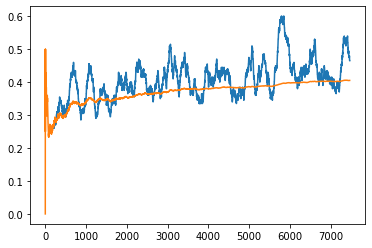

In [17]:
cumulative_avg = np.cumsum(rewards) / np.linspace(1, len(rewards), len(rewards))
plt.plot(pd.Series(rewards).rolling(200).mean(), label='epsilon')
plt.plot(cumulative_avg, label='epsilon')

In [18]:
def replay_score(history, df, t, batch_size, recs):
    # reward if rec matches logged data, ignore otherwise
    actions = df[t:t+batch_size]
    actions = actions.loc[actions['movieId'].isin(recs)]
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = history.append(actions)
    action_liked = actions[['movieId', 'liked']]
    return history, action_liked

In [20]:
# simulation params: slate size, batch size (number of events per training iteration)
slate_size = 5
batch_size = 10


# initialize empty history 
# (the algorithm should be able to see all events and outcomes prior to the current timestep, but no current or future outcomes)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

# initialize empty list for storing scores from each step
rewards = []

for t in range(df.shape[0]//batch_size):
    t = t * batch_size
    # generate recommendations from a random policy
    recs = np.random.choice(df.movieId.unique(), size=(slate_size), replace=False)
    # send recommendations and dataset to a scoring function so the model can learn & adjust its policy in the next iteration
    history, action_score = replay_score(history, df, t, batch_size, recs)
    if action_score is not None:
        action_score = action_score.liked.tolist()
        rewards.extend(action_score)

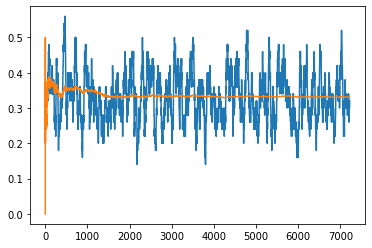

In [30]:
cumulative_rewards = np.cumsum(rewards)/ np.linspace(1, len(rewards), len(rewards))
trailing_ctr = np.asarray(pd.Series(rewards).rolling(50).mean())
plt.plot(trailing_ctr,label='epsilon')
plt.plot(cumulative_rewards,label='epsilon')

In [27]:
trailing_ctr.shape

(7222,)